### Import libraries

In [291]:
# Import library
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Import files

In [292]:
anime_data = pd.read_csv('../anime_cleaned.csv')

### Removing some blank data

In [293]:
anime_data['episodes'].replace('', np.nan, inplace=True)
anime_data.dropna(subset=['episodes'], inplace=True)
anime_data['episodes'] = anime_data['episodes'].astype('int64')
linreg = LinearRegression()

### Convert categorical data (one-hot encoding + ordinal data)

In [294]:
anime_data['broadcast'] = anime_data['broadcast'].astype('category')
anime_data['broadcast'] = anime_data['broadcast'].cat.reorder_categories(
    ['Mondays', 'Tuesdays', 'Wednesdays', 'Thursdays', 'Fridays', 'Saturdays', 'Sundays', 'Unknown', 'Not schedule'], ordered=True)

anime_data['broadcast'] = anime_data['broadcast'].cat.codes

# one_hot_broadcast = pd.get_dummies(anime_data['broadcast'], drop_first=True)
# anime_data = anime_data.join(one_hot_broadcast)
# anime_data



In [295]:
# anime_data['broadcast'] = anime_data['broadcast'].astype('category')
# anime_data['broadcast'] = anime_data['broadcast'].cat.reorder_categories(
#     ['Mondays', 'Tuesdays', 'Wednesdays', 'Thursdays', 'Fridays', 'Saturdays', 'Sundays', 'Unknown', 'Not schedule'], ordered=True)

# anime_data['broadcast'] = anime_data['broadcast'].cat.codes
# anime_data['broadcast']

### Helper function

In [296]:
def linear_regression(predictors, response):
    # Extract Response and Predictors
    # predictors = ["HP", "Attack", "Defense"]
    
    y = pd.DataFrame(anime_data[response])
    X = pd.DataFrame(anime_data[predictors])
    
    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    
    # Linear Regression using Train Data
    # linreg = LinearRegression()         # create the linear regression object
    linreg.fit(X_train, y_train)        # train the linear regression model
    
    # Coefficients of the Linear Regression line
    print('Intercept of Regression \t: b = ', linreg.intercept_)
    print('Coefficients of Regression \t: a = ', linreg.coef_)
    print()
    
    # Print the Coefficients against Predictors
    print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
    print()
    
    # Predict Response corresponding to Predictors
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)
    
    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].scatter(y_train, y_train_pred, color = "blue")
    axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
    axes[0].set_xlabel("True values of the Response Variable (Train)")
    axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
    axes[1].scatter(y_test, y_test_pred, color = "green")
    axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
    axes[1].set_xlabel("True values of the Response Variable (Test)")
    axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
    plt.show()
    
    print()
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
    print()
    
    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
    print()

### Predicting `score` with `episodes` and `duration`

Intercept of Regression 	: b =  [7.49551484]
Coefficients of Regression 	: a =  [[-9.62527216e-05]]

   Predictors  Coefficients
0  popularity     -0.000096



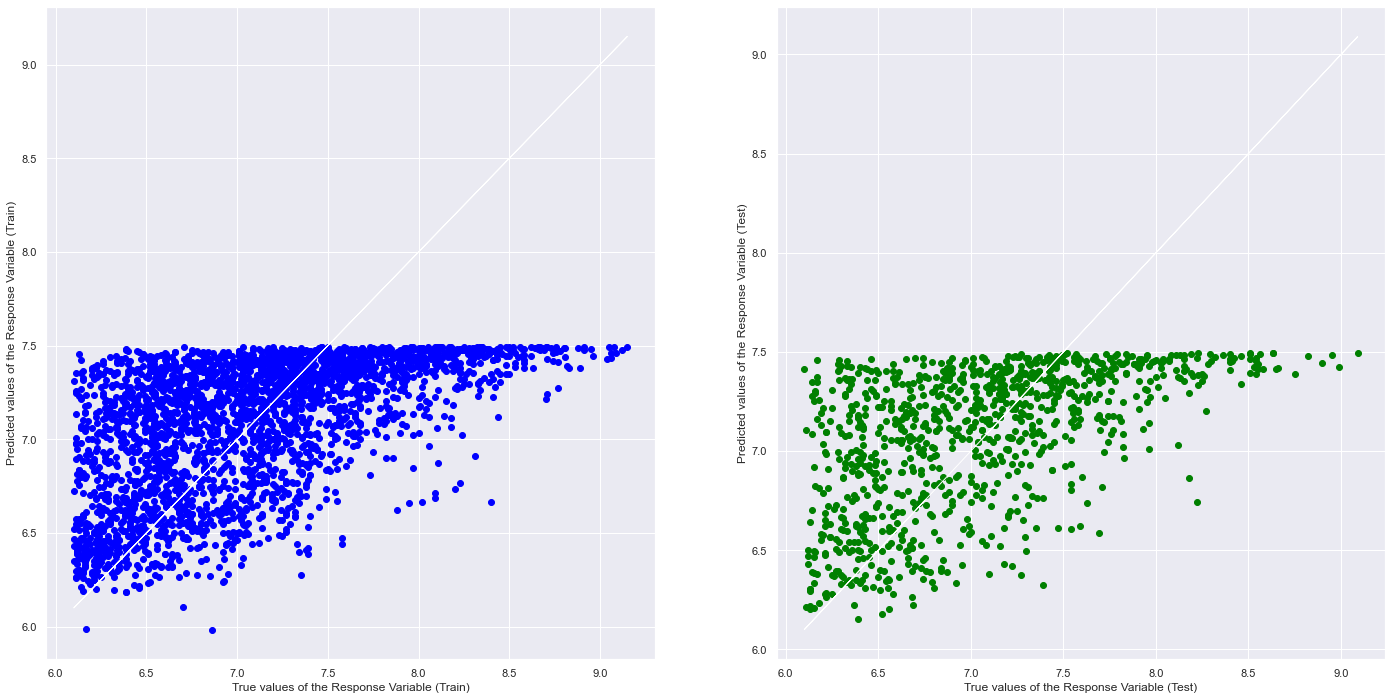


Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.31216479297049515
Mean Squared Error (MSE) 	: 0.267597195631804

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.2870806270618973
Mean Squared Error (MSE) 	: 0.25903487711328954



In [297]:
linear_regression(['broadcast', 'popularity'], 'score')

#### Prediction

In [298]:
# Extract Pokemons for Prediction
anime_pred = anime_data[anime_data["title"].isin(["Steins;Gate", "Dr. Stone", "One Piece", "Mobile Suit Gundam 00",
                                                 "Naruto: Shippuuden", "Jujutsu Kaisen", "Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season Part 2"])]
anime_pred


,Unnamed: 0,Unnamed: 0.1,rank,title,score,scored_by_users,type,episodes,status,year aired,...,studios,source,genres,main genre,theme,demographic,duration,rating,popularity,url
2,2,2,3,Steins;Gate,9.09,1161139,TV,24,Finished Airing,2011,...,White Fox,Visual novel,"Drama, Sci-Fi, Suspense",Drama,Psychological,All,24,PG-13 - Teens 13 or older,13,https://myanimelist.net/anime/9253/Steins_Gate
43,56,56,107,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...,8.51,335734,TV,12,Finished Airing,2021,...,White Fox,Light novel,"Drama, Fantasy, Suspense",Drama,Psychological,All,28,R - 17+ (violence & profanity),244,https://myanimelist.net/anime/42203/Re_Zero_ka...
100,161,161,1062,Jujutsu Kaisen,7.71,9325,ONA,3,Finished Airing,2018,...,Yokohama Animation Lab,Manga,NaN,Unknown,Unknown,Shounen,1,G - All Ages,2918,https://myanimelist.net/anime/38777/Jujutsu_Ka...
650,1184,1184,235,Dr. Stone,8.30,791619,TV,24,Finished Airing,2019,...,TMS Entertainment,Manga,"Adventure, Comedy, Sci-Fi",Adventure,Unknown,Shounen,24,PG-13 - Teens 13 or older,60,https://myanimelist.net/anime/38691/Dr_Stone
938,1739,1739,290,Naruto: Shippuuden,8.23,1201683,TV,500,Finished Airing,2007,...,Studio Pierrot,Manga,"Action, Adventure, Comedy",Action,Unknown,Shounen,23,PG-13 - Teens 13 or older,16,https://myanimelist.net/anime/1735/Naruto__Shi...
1759,3350,3350,401,Mobile Suit Gundam 00,8.12,109152,TV,25,Finished Airing,2007,...,Sunrise,Original,"Action, Drama, Sci-Fi",Action,Unknown,All,24,R - 17+ (violence & profanity),945,https://myanimelist.net/anime/2581/Mobile_Suit...
2277,4467,4467,68,One Piece,8.62,1014947,TV,1013,Currently Airing,1999,...,Toei Animation,Manga,"Action, Adventure, Comedy, Drama, Fantasy",Action,Super Power,Shounen,24,PG-13 - Teens 13 or older,26,https://myanimelist.net/anime/21/One_Piece


In [299]:
# Extract Predictors for Prediction
X_pred = pd.DataFrame(anime_pred[['broadcast', 'popularity']])

# linreg = LinearRegression()
# Predict Response corresponding to Predictors
y_pred = linreg.predict(X_pred)
y_pred

array([[7.49426356],
       [7.47202918],
       [7.2146494 ],
       [7.48973968],
       [7.4939748 ],
       [7.40455602],
       [7.49301227]])

In [300]:
# Summarize the Actuals, Predictions and Errors
y_pred = pd.DataFrame(y_pred, columns = ["PredScore"], index = anime_pred.index)
animedata_acc = pd.concat([anime_pred[["title", "score"]], y_pred], axis = 1)

y_errs = 100 * abs(animedata_acc["score"] - animedata_acc["PredScore"]) / animedata_acc["score"]
y_errs = pd.DataFrame(y_errs, columns = ["Error"], index = anime_pred.index)
animedata_acc= pd.concat([animedata_acc, y_errs], axis = 1)

animedata_acc

,title,score,PredScore,Error
2,Steins;Gate,9.09,7.494264,17.554856
43,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...,8.51,7.472029,12.197072
100,Jujutsu Kaisen,7.71,7.214649,6.424781
650,Dr. Stone,8.30,7.489740,9.762173
938,Naruto: Shippuuden,8.23,7.493975,8.943198
1759,Mobile Suit Gundam 00,8.12,7.404556,8.810886
2277,One Piece,8.62,7.493012,13.074104
